# Encoding fingerprint latent representation

# Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA
from pathlib import Path

from chemprop import data, featurizers, models

# Change model input here

In [2]:
chemprop_dir = Path.cwd().parent
checkpoint_path = chemprop_dir / "tests/data/example_model_v2_regression_mol.ckpt" # path to the checkpoint file.
# If the checkpoint file is generated using the training notebook,
# it will be in the `checkpoints` folder with name similar to `checkpoints/epoch=19-step=180.ckpt`.

## Load model

In [3]:
mpnn = models.MPNN.load_from_checkpoint(checkpoint_path)
mpnn.eval()
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (W_d): Linear(in_features=300, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
  )
)

# Change data input here

In [4]:
test_path = '../tests/data/smis.csv'
smiles_column = 'smiles'

## Load data

In [5]:
df_test = pd.read_csv(test_path)

smis = df_test[smiles_column]

test_data = [data.MoleculeDatapoint.from_smi(smi) for smi in smis]
test_data[:5]

[MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7fec884f2ab0>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7fec884f2b90>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='COc1cc(OC)c(cc1NC(=O)CSCC(=O)O)S(=O)(=O)N2C(C)CCc3ccccc23', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7fec884f2c70>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='COC(=O)[C@@H](N1CCc2sccc2C1)c3ccccc3Cl', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7fec884f2d50>, y=None, weight=1.0, gt_mask=None, lt_mask=None, x_d=None, x_phase=None, name='OC[C@H](O)CN1C(=O)C(Cc2ccccc12)NC(=O)c3cc4cc(Cl)sc4[nH]3', V_f=None, E_f=None, V_d=None),
 MoleculeDatapoint(mol=<rdkit.Chem.rdchem.Mol object at 0x7fec884f2e30

# Get featurizer

In [6]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

# Get datasets

In [7]:
test_dset = data.MoleculeDataset(test_data, featurizer=featurizer)
test_loader = data.MolGraphDataLoader(test_dset, shuffle=False)

# Calculate fingerprints

`models.MPNN.encoding(inputs : BatchMolGraph, index : int)` returns the learned representations for a given batch of input molecules. An index of 0 denotes the post-aggregation representation through a 0-layer MLP, while an index of 1 represents the output from the first linear layer in the FFN, and so forth.

In [8]:
with torch.no_grad():
    fingerprints = [
        mpnn.encoding(batch.bmg, batch.V_d, batch.X_d, index=0)
        for batch in test_loader
    ]
    fingerprints = torch.cat(fingerprints, 0)

fingerprints.shape

torch.Size([100, 300])

In [9]:
with torch.no_grad():
    encodings = [
        mpnn.encoding(batch.bmg, batch.V_d, batch.X_d, index=1)
        for batch in test_loader
    ]
    encodings = torch.cat(encodings, 0)

encodings.shape

torch.Size([100, 300])

# Using fingerprints

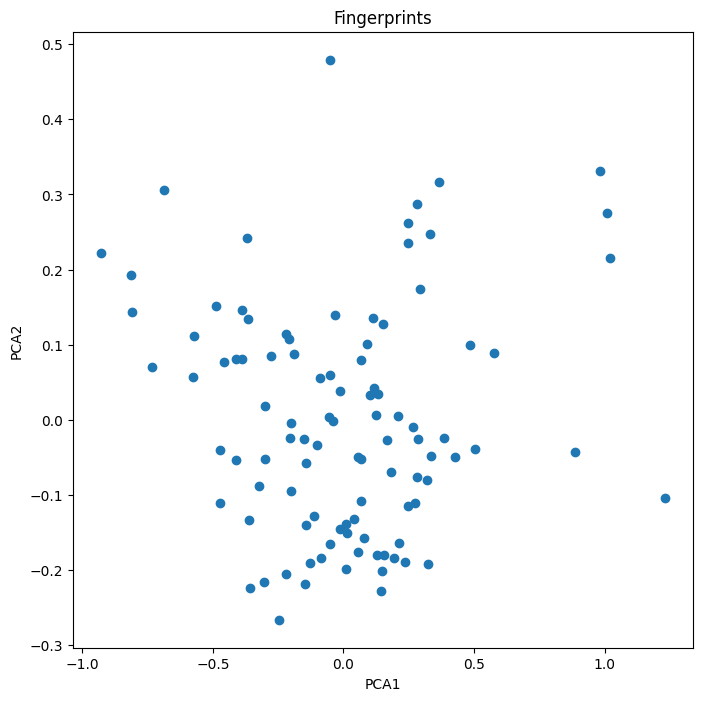

In [10]:
fingerprints = fingerprints.detach()

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(fingerprints)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Fingerprints")
ax.set_xlabel('PCA1'); ax.set_ylabel('PCA2')

ax.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.show()

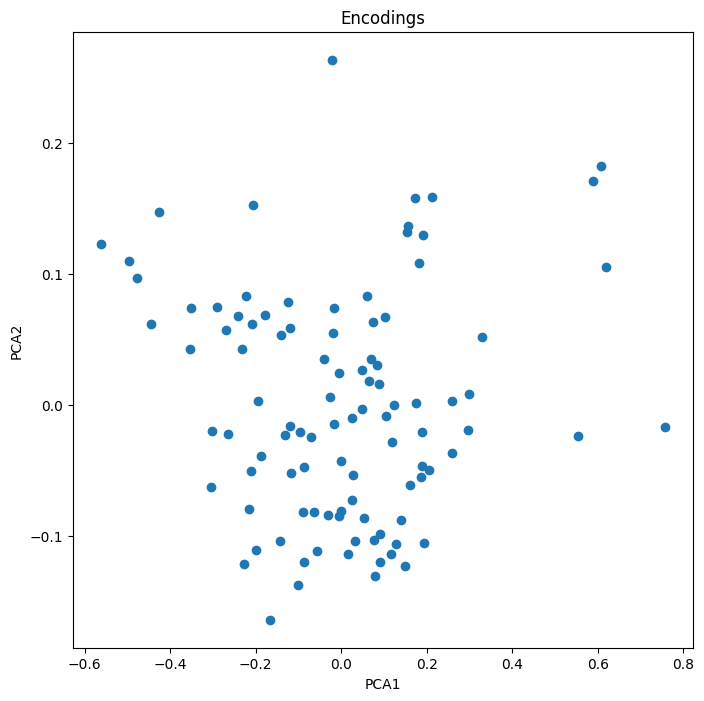

In [11]:
encodings = encodings.detach()

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(encodings)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1)
ax.set_title("Encodings")
ax.set_xlabel('PCA1'); ax.set_ylabel('PCA2')

ax.scatter(principalComponents[:, 0], principalComponents[:, 1])
plt.show()